# 9장 NeRF
This is a PyTorch implementation based on the paper: https://arxiv.org/abs/2003.08934. The code takes mostly after the officially tiny nerf implementation: https://colab.research.google.com/github/bmild/nerf/blob/master/tiny_nerf.ipynb

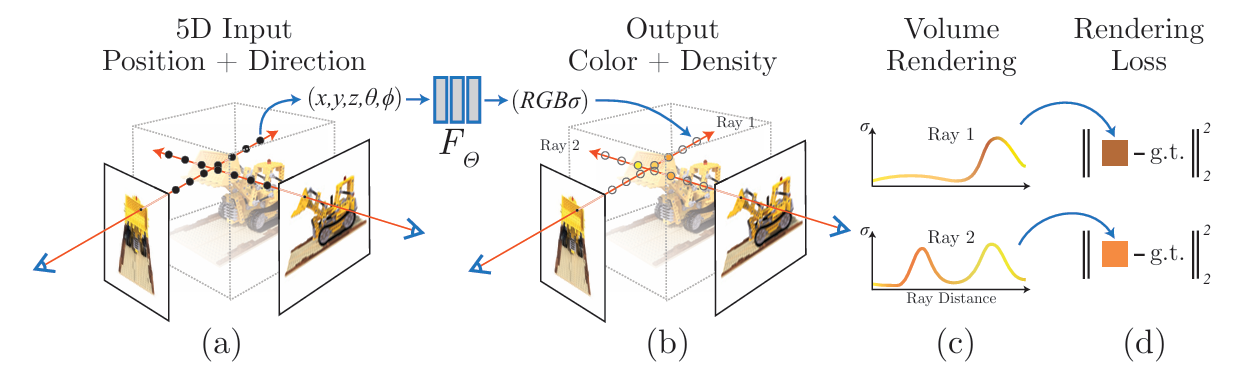

## Imports + Data


In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.init as init
import time
import numpy as np
import torch.nn.functional as F
import os
from tqdm import tqdm
from ipywidgets import interactive, widgets


device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
# if not os.path.exists('tiny_nerf_data.npz'):
#     !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

## Encoding + Model

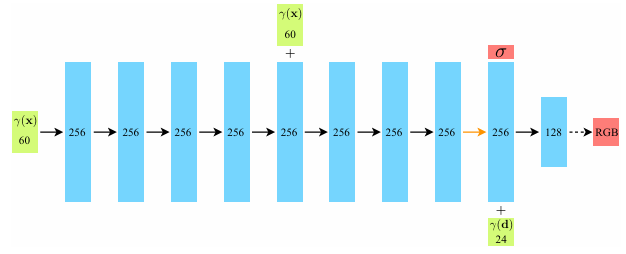

$$\gamma(p) = (\sin(2^0\pi p), \cos(2^0\pi p), \dots, \sin(2^{L-1}\pi p), \cos(2^{L-1}\pi p))$$

In [ ]:
def encoding(x, L=10):
  res = []
  for i in range(L):
    for fn in [torch.sin, torch.cos]:
      res.append(fn(2 ** i * torch.pi * x))
  return torch.cat(res,dim=-1)

In [3]:
x = torch.Tensor([3.1,5.6,7.3]) # x, y, z
y = encoding(x,L=4)
y

tensor([ 3.1000,  5.6000,  7.3000, -0.3090, -0.9511, -0.8090, -0.9511,  0.3090,
        -0.5878,  0.5878, -0.5878,  0.9511,  0.8090, -0.8090, -0.3090,  0.9511,
         0.9511, -0.5878,  0.3090,  0.3090, -0.8090,  0.5878,  0.5878,  0.9511,
        -0.8090, -0.8090,  0.3090])

In [ ]:
class NeRF(nn.Module):
  def __init__(self, pos_enc_dim= 60, view_enc_dim= 24, hidden= 256) -> None:
     super().__init__()

     self.linear1 = nn.Sequential(nn.Linear(pos_enc_dim,hidden),nn.ReLU())

     self.pre_skip_linear = nn.Sequential()
     for _ in range(4):
      self.pre_skip_linear.append(nn.Linear(hidden,hidden))
      self.pre_skip_linear.append(nn.ReLU())

     self.linear_skip = nn.Sequential(nn.Linear(pos_enc_dim+hidden,hidden),nn.ReLU())

     self.post_skip_linear = nn.Sequential()
     for _ in range(2):
      self.post_skip_linear.append(nn.Linear(hidden,hidden))
      self.post_skip_linear.append(nn.ReLU())

     self.density_layer = nn.Sequential(nn.Linear(hidden,1),nn.ReLU())

     self.linear2 = nn.Linear(hidden,hidden)

     self.color_linear1 = nn.Sequential(nn.Linear(hidden+view_enc_dim,hidden//2),nn.ReLU())
     self.color_linear2 = nn.Sequential(nn.Linear(hidden//2,3), nn.Sigmoid())

  def forward(self, input):

    positions = input[...,:3]
    view_dirs = input[...,3:]

    # Encode
    pos_enc = encoding(positions,L=10)
    view_enc = encoding(view_dirs,L=4)

    x = self.linear1(pos_enc)
    x = self.pre_skip_linear(x)

    # Skip connection
    x = torch.cat([x,pos_enc],dim=-1)
    x = self.linear_skip(x)

    x = self.post_skip_linear(x)

    # Density
    sigma = self.density_layer(x)

    x = self.linear2(x)

    # View Encoding
    x = torch.cat([x,view_enc],dim=-1)
    x = self.color_linear1(x)

    # Color Prediction
    rgb = self.color_linear2(x)

    return torch.cat([sigma,rgb],dim=-1)


## Get Ray + Render

In [ ]:
## Meshgrid
W = 3; H = 4; focal = 1
i, j = torch.meshgrid(
      torch.arange(W, dtype=torch.float32, device=device),
      torch.arange(H, dtype=torch.float32, device=device),
      indexing='xy' # ensures that i represents the width and j represents the height, following standard image conventions.
  )

print("i = \n",  i)
print("j = \n",  j)
print('z = ')
print(torch.ones_like(i))

print("+"*50)
print("i = \n",  i)
print("-j = \n",  -j)
print('-z = ')
print(-torch.ones_like(i))


i = 
 tensor([[0., 1., 2.],
        [0., 1., 2.],
        [0., 1., 2.],
        [0., 1., 2.]], device='cuda:0')
j = 
 tensor([[0., 0., 0.],
        [1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.]], device='cuda:0')
z = 
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')
++++++++++++++++++++++++++++++++++++++++++++++++++
i = 
 tensor([[0., 1., 2.],
        [0., 1., 2.],
        [0., 1., 2.],
        [0., 1., 2.]], device='cuda:0')
-j = 
 tensor([[-0., -0., -0.],
        [-1., -1., -1.],
        [-2., -2., -2.],
        [-3., -3., -3.]], device='cuda:0')
-z = 
tensor([[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]], device='cuda:0')


In [ ]:
## image centering

dirs = torch.stack(
      [(i - W * .5) / focal, -(j - H * .5) / focal, -torch.ones_like(i, device = device)], -1
  )

# dirs = torch.stack(
#       [i, -j, -torch.ones_like(i, device = device)], -1
#   )

print(dirs)
print(dirs.shape)
dirs[..., None, :].shape


tensor([[[-1.5000,  2.0000, -1.0000],
         [-0.5000,  2.0000, -1.0000],
         [ 0.5000,  2.0000, -1.0000]],

        [[-1.5000,  1.0000, -1.0000],
         [-0.5000,  1.0000, -1.0000],
         [ 0.5000,  1.0000, -1.0000]],

        [[-1.5000, -0.0000, -1.0000],
         [-0.5000, -0.0000, -1.0000],
         [ 0.5000, -0.0000, -1.0000]],

        [[-1.5000, -1.0000, -1.0000],
         [-0.5000, -1.0000, -1.0000],
         [ 0.5000, -1.0000, -1.0000]]], device='cuda:0')
torch.Size([4, 3, 3])


torch.Size([4, 3, 1, 3])

In [ ]:
## mat1*mat2
mat1 = torch.tensor([[1, 2, 3]])
mat2 = torch.full((3, 3), 10)
print(mat1)
print(mat2)
print(mat1*mat2)
print(torch.sum(mat1*mat2, -1))

tensor([[1, 2, 3]])
tensor([[10, 10, 10],
        [10, 10, 10],
        [10, 10, 10]])
tensor([[10, 20, 30],
        [10, 20, 30],
        [10, 20, 30]])
tensor([60, 60, 60])


In [ ]:
## torch.from_numpy
a =  np.array([1, 2, 4])

b = torch.tensor(a)
c = torch.from_numpy(a)


a[0] = 10

print(a)
print(b)
print(c)

[10  2  4]
tensor([1, 2, 4])
tensor([10,  2,  4])


In [ ]:
## rand
near = 2; far = 6; N_samples = 6
z_vals = torch.linspace(near, far, steps=N_samples, device=device)
print("z_vals = \n", z_vals)

# torch.rand(*z_vals.shape[:-1], N_samples, device=device) * (far - near) / N_samples
torch.rand(*z_vals.shape[:-1], N_samples, device=device) * (far - near) / N_samples


z_vals = 
 tensor([2.0000, 2.8000, 3.6000, 4.4000, 5.2000, 6.0000], device='cuda:0')


tensor([0.0192, 0.0702, 0.6064, 0.1827, 0.3709, 0.2194], device='cuda:0')

In [40]:
z_vals.shape[:-1]

scalar_val = torch.tensor(0)
print(scalar_val, scalar_val.shape)

tensor(0) torch.Size([])


In [49]:
## torch.cumprod
a = torch.arange(1, 4)
print('a = ', a)
print(torch.cumprod(a, dim = -1) )

a =  tensor([1, 2, 3])
tensor([1, 2, 6])


In [ ]:
def get_rays(H, W, focal, c2w):
  """
  Generate rays for a given camera configuration.

  Args:
    H: Image height.
    W: Image width.
    focal: Focal length.
    c2w: Camera-to-world transformation matrix (4x4).

  Returns:
    rays_o: Ray origins (H*W, 3).
    rays_d: Ray directions (H*W, 3).
  """
  device = c2w.device  # Get the device of c2w
  focal = torch.from_numpy(focal).to(device) # call by reference
  # print(type(H), type(W), type(focal), type(c2w))

  i, j = torch.meshgrid(
      torch.arange(W, dtype=torch.float32, device=device),
      torch.arange(H, dtype=torch.float32, device=device),
      indexing='xy' # ensures that i represents the width and j represents the height, following standard image conventions.
  )
  dirs = torch.stack(
      [(i - W * .5) / focal, -(j - H * .5) / focal, -torch.ones_like(i, device = device)], -1
  )
 # dirs = [H, W, 1, (x, y, z)] * c2w[:3, :3] (# Intrinsic matrix)
  rays_d = torch.sum(dirs[..., None, :] * c2w[:3, :3], -1)  # a cone beam model,forming a perspective projection
  # rays_d = torch.Size([100, 100, 3])
  rays_d = rays_d.view(-1, 3)
  # rays_d = torch.Size([10000, 3])
  rays_o = c2w[:3, -1].expand(rays_d.shape)
  # rays_o = torch.Size([10000, 3])
  return rays_o, rays_d

# rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=n_samples, device=device, rand=True)
def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, device, rand=False, embed_fn=None, chunk=1024*4):
    # This function processes large inputs in chunks to prevent memory overload when calling
    def batchify(fn, chunk):
        return lambda inputs: torch.cat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0) # [0, 4096, 8192]

    # Sampling
    z_vals = torch.linspace(near, far, steps=N_samples, device=device)

    if rand:
        z_vals += torch.rand(*z_vals.shape[:-1], N_samples, device=rays_o.device) * (far - near) / N_samples
    # z_vals shape = torch.Size([64])
   
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None] # z_vals shape = torch.Size([64, 1])
    # pts.shape = torch.Size([10000, 64, 3])

    # Normalize view directions
    view_dirs = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
    view_dirs = view_dirs[..., None, :].expand(pts.shape)

    input_pts = torch.cat((pts, view_dirs), dim=-1)
    raw = batchify(network_fn, chunk)(input_pts)

    # Apply activations here instead of in network
    sigma_a = raw[...,0]  # Shape: [batch, N_samples]
    rgb = raw[...,1:]    # Shape: [batch, N_samples, 3]

    # Improved volume rendering
    dists = z_vals[..., 1:] - z_vals[..., :-1]  # Shape: [batch, N_samples-1]
    dists = torch.cat([dists, torch.tensor([1e10], device=device)], -1)

    # No need to manually expand dists as broadcasting will handle it
    alpha = 1. - torch.exp(-sigma_a * dists)  # Shape: [batch, N_samples] , cdf of exponetial
    alpha = alpha.unsqueeze(-1)  # Shape: [batch, N_samples, 1] 

    ## Computing transmittance: Transmittance (T) represents how much light reaches each point.
    ones_shape = (alpha.shape[0], 1, 1)
    T = torch.cumprod(
        torch.cat([
            torch.ones(ones_shape, device=device),  # (10000, 1, 1)
            1. - alpha + 1e-10                      # (10000, 64, 1)
        ], dim=1),
        dim=1
    )[:, :-1]  # Shape: [batch, N_samples, 1]

    weights = alpha * T  # Shape: [batch, N_samples, 1]

    # Compute final colors and depths, accumulation
    rgb_map = torch.sum(weights * rgb, dim=1)  # Sum along sample dimension
    # rgb_map.shape = torch.Size([10000, 3])
    depth_map = torch.sum(weights.squeeze(-1) * z_vals, dim=-1)  # Shape: [batch]
    acc_map = torch.sum(weights.squeeze(-1), dim=-1)  # Shape: [batch]

    return rgb_map, depth_map, acc_map

## Train Loop

In [ ]:
def train(images,poses,H,W,focal,testpose,testimg,device):

    print(f"Using device: {device}")
    model = NeRF().to(device)

    criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(),lr=5e-4)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99) # decays the learning rate (LR) by multiplying it by gamma=0.99 after each epoch
 
    n_iter = 1000
    n_samples = 64
    i_plot = 50
    psnrs = []
    iternums = []
    t = time.time()

    # Convert data to tensors and move to device ONCE
    images_tensor = torch.from_numpy(images).float().to(device)
    poses_tensor = torch.from_numpy(poses).float().to(device)

    for i in range(n_iter):

        img_i = np.random.randint(images.shape[0])

        target = images_tensor[img_i]  # Use the corresponding image
        pose = poses_tensor[img_i]     # Use the corresponding pose

        rays_o, rays_d = get_rays(H, W, focal, pose)

        optimizer.zero_grad()

        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=n_samples, device=device, rand=True)

        rgb = rgb.reshape(H,W,3)

        loss = criterion(rgb, target)

        loss.backward()
        optimizer.step()

        if i % i_plot == 0:
            print(f'Iteration: {i}, Loss: {loss.item():.6f}, Time: {(time.time() - t) / i_plot:.2f} secs per iter')
            t = time.time()

            with torch.no_grad():
                rays_o, rays_d = get_rays(H, W, focal, testpose)
                rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6.,
                                           N_samples=n_samples, device=device)
                rgb = rgb.reshape(H, W, 3)
                loss = criterion(rgb, testimg)
                psnr = -10. * torch.log10(loss)

                psnrs.append(psnr.item())
                iternums.append(i)

                plt.figure(figsize=(10,4))
                plt.subplot(121)
                plt.imshow(rgb.cpu().detach())
                plt.title(f'Iteration: {i}')
                plt.subplot(122)
                plt.plot(iternums, psnrs)
                plt.title('PSNR')
                plt.show()

    return model

## Load Data

image shape =  (106, 100, 100, 3)
pose shape =  (106, 4, 4)
focal length =  138.88887889922103


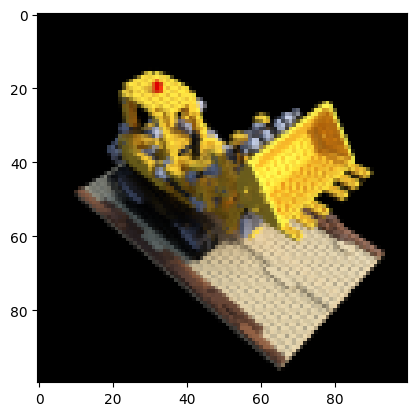

In [14]:
file_path = os.path.join(os.getcwd(),'data', 'tiny_nerf_data.npz')
data = np.load(file_path)
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print("image shape = ", images.shape)
print("pose shape = ", poses.shape)
print("focal length = ", focal)

device = "cuda" if torch.cuda.is_available() else "cpu"

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]
plt.imshow(testimg)
plt.show()
testimg =  torch.from_numpy(testimg).float().to("cuda")
testpose = torch.from_numpy(testpose).float().to("cuda")

## Train

Using device: cuda
Iteration: 0, Loss: 0.081648, Time: 0.02 secs per iter


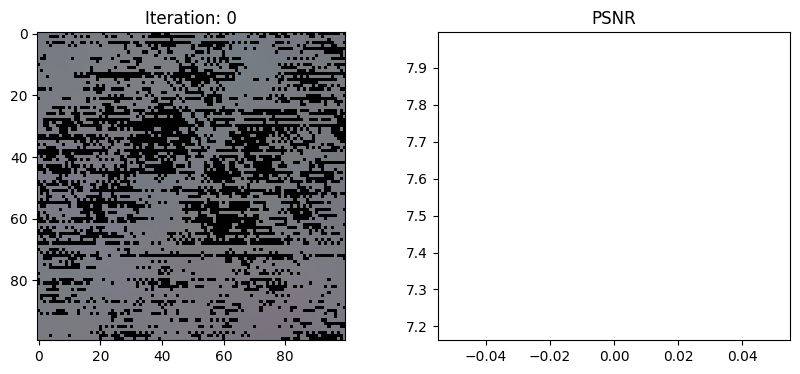

Iteration: 50, Loss: 0.054801, Time: 0.81 secs per iter


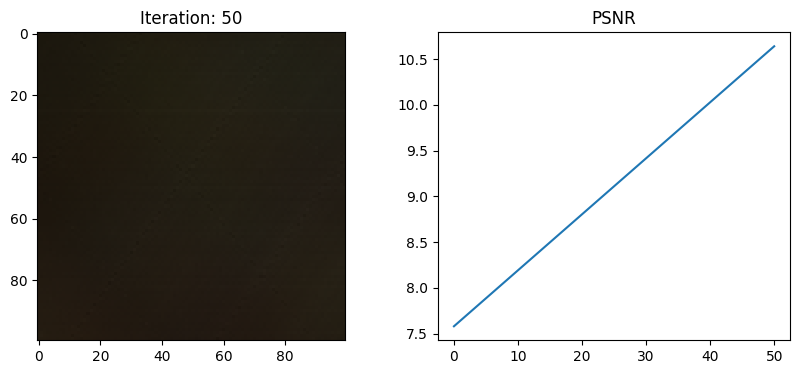

Iteration: 100, Loss: 0.101059, Time: 0.80 secs per iter


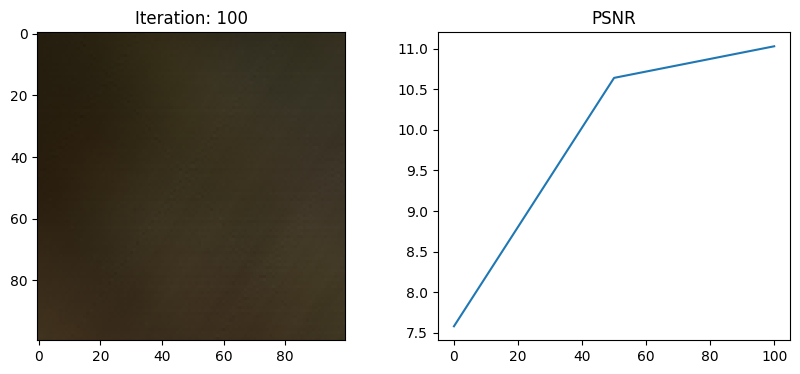

Iteration: 150, Loss: 0.052301, Time: 0.80 secs per iter


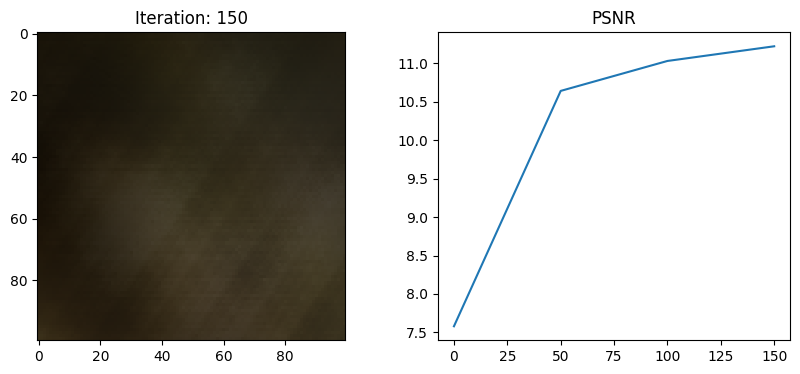

Iteration: 200, Loss: 0.042073, Time: 0.80 secs per iter


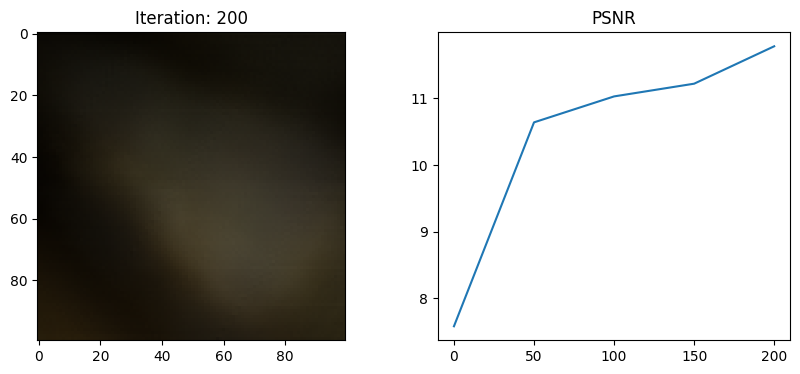

Iteration: 250, Loss: 0.021877, Time: 0.78 secs per iter


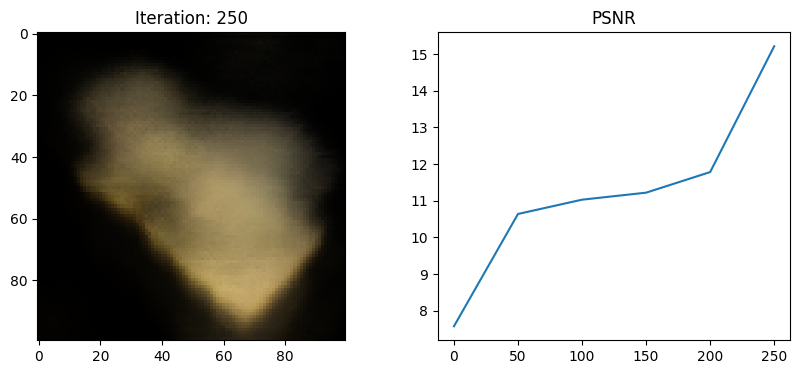

Iteration: 300, Loss: 0.017164, Time: 0.78 secs per iter


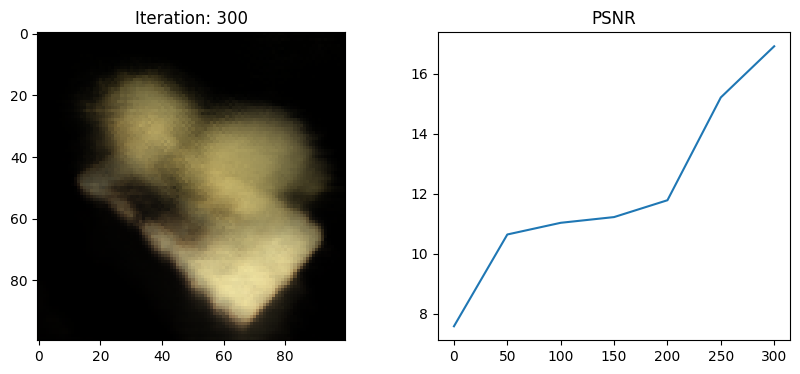

Iteration: 350, Loss: 0.015522, Time: 0.77 secs per iter


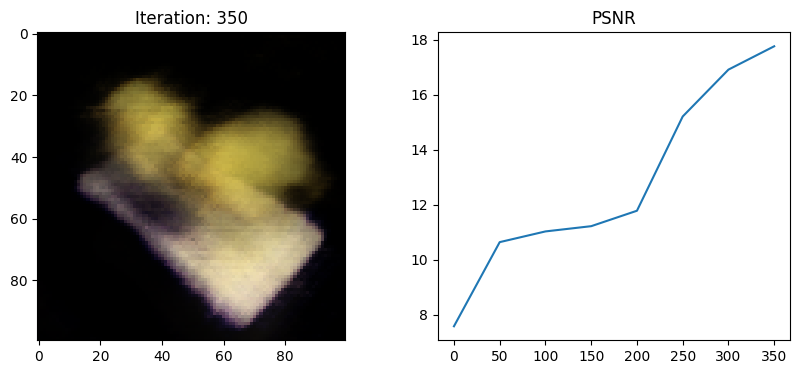

Iteration: 400, Loss: 0.015200, Time: 0.77 secs per iter


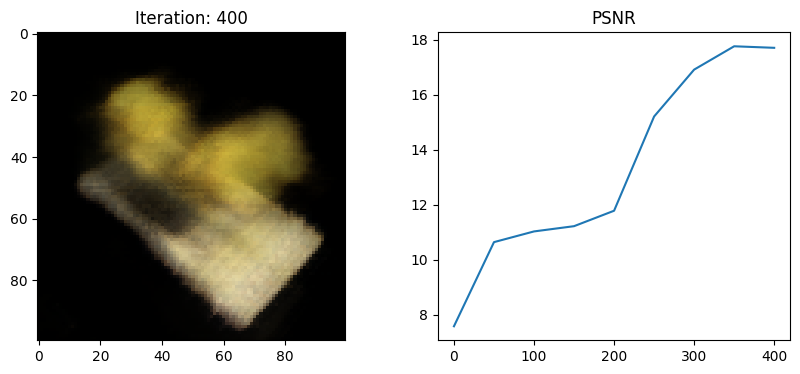

Iteration: 450, Loss: 0.017326, Time: 0.77 secs per iter


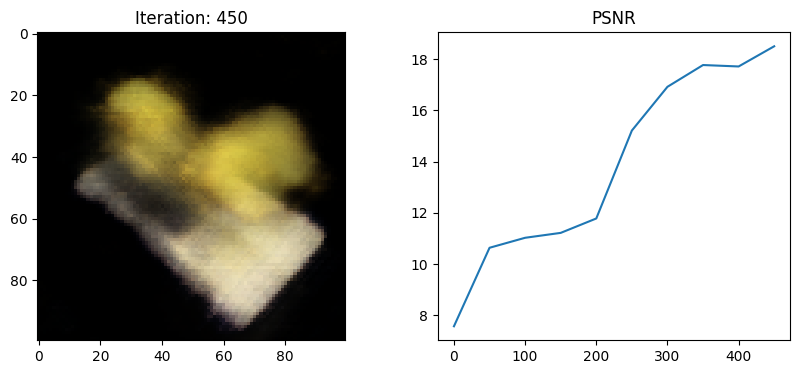

Iteration: 500, Loss: 0.010243, Time: 0.77 secs per iter


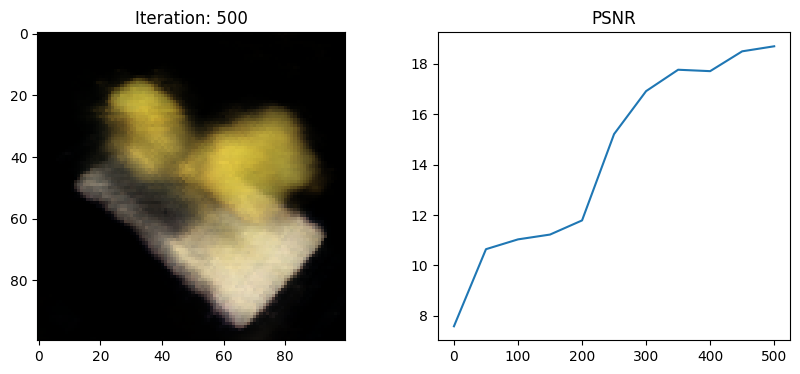

Iteration: 550, Loss: 0.004872, Time: 0.77 secs per iter


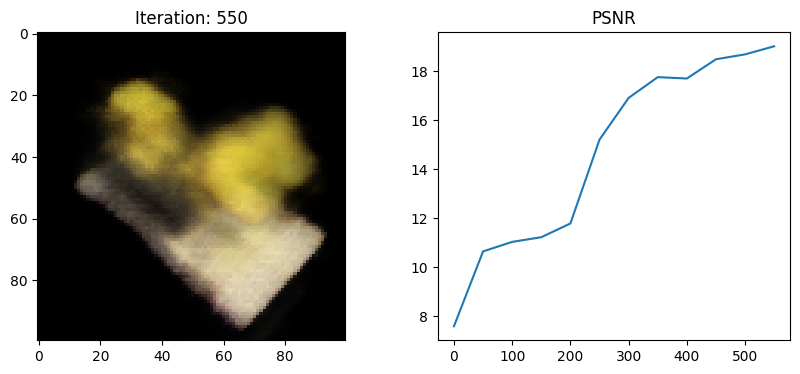

Iteration: 600, Loss: 0.007803, Time: 0.77 secs per iter


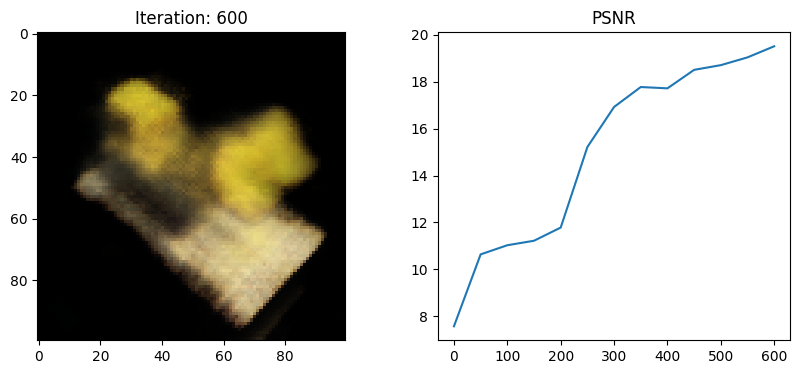

Iteration: 650, Loss: 0.009860, Time: 0.76 secs per iter


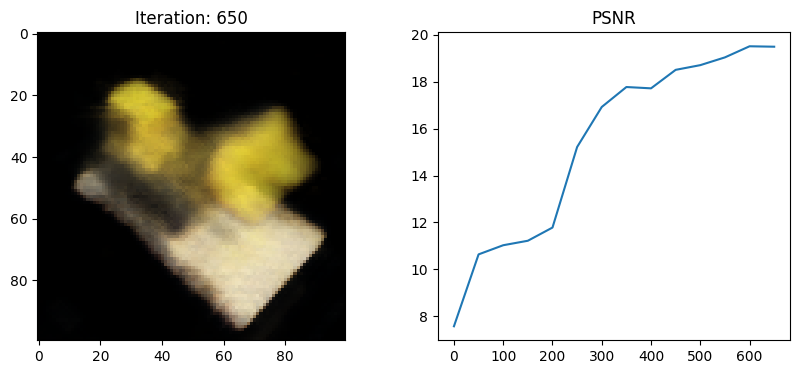

Iteration: 700, Loss: 0.005969, Time: 0.76 secs per iter


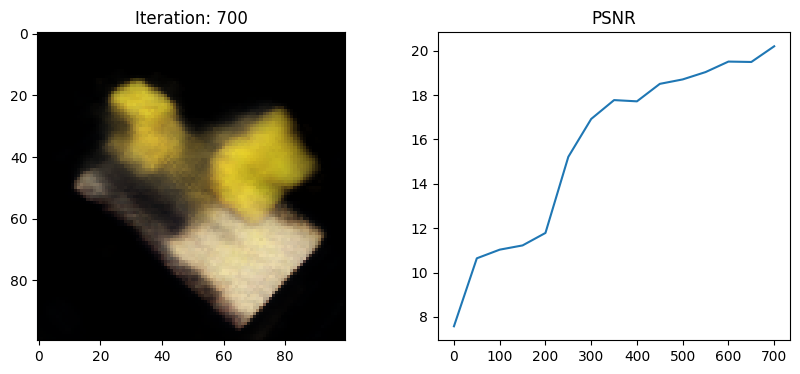

Iteration: 750, Loss: 0.010574, Time: 0.76 secs per iter


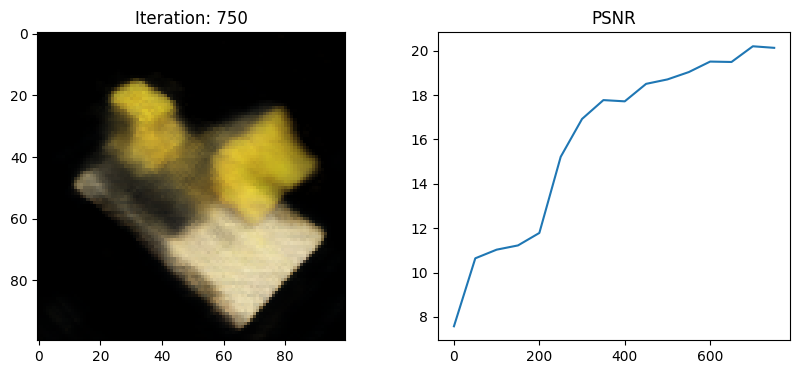

Iteration: 800, Loss: 0.007468, Time: 0.76 secs per iter


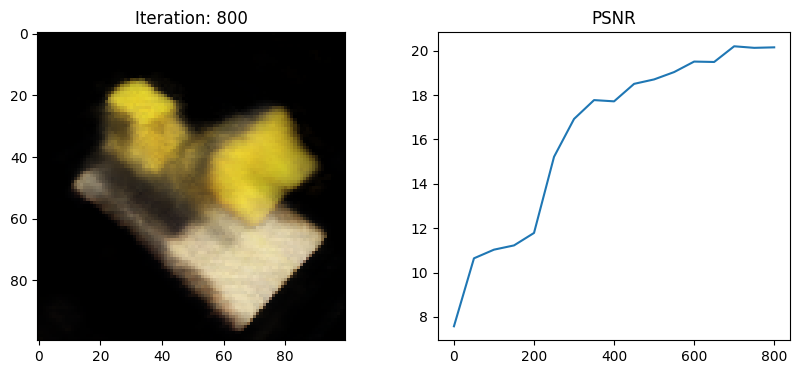

Iteration: 850, Loss: 0.010832, Time: 0.76 secs per iter


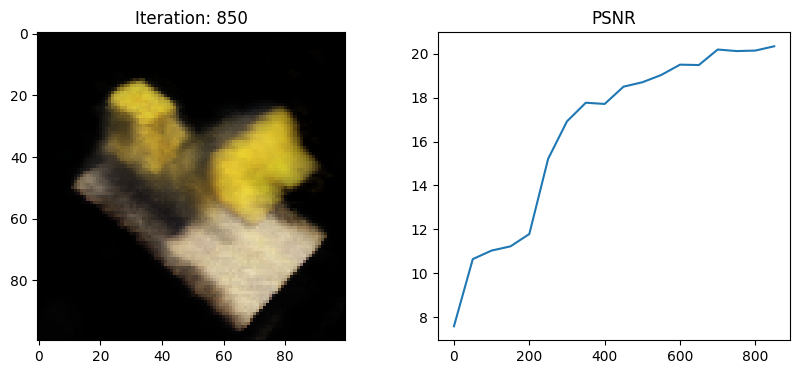

Iteration: 900, Loss: 0.010579, Time: 0.76 secs per iter


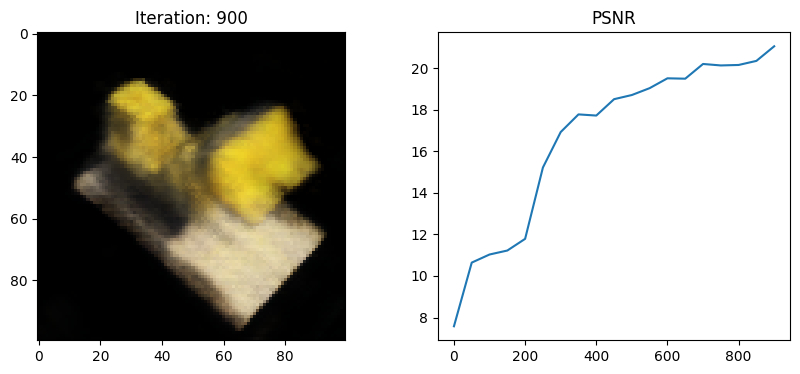

Iteration: 950, Loss: 0.007801, Time: 0.76 secs per iter


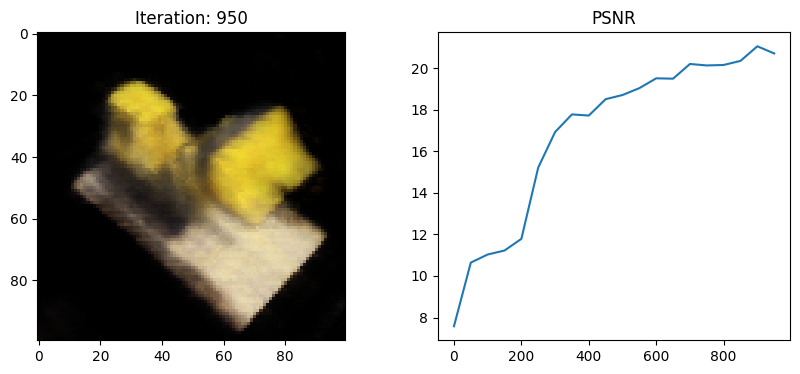

In [ ]:
model = train(images,poses,H,W,focal,testpose,testimg,device)

## Render Video

In [ ]:
# Transformation matrices in PyTorch
trans_t = lambda t: torch.tensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, t],
    [0, 0, 0, 1]
], dtype=torch.float32)

rot_phi = lambda phi: torch.tensor([
    [1, 0, 0, 0],
    [0, torch.cos(phi), -torch.sin(phi), 0],
    [0, torch.sin(phi), torch.cos(phi), 0],
    [0, 0, 0, 1]
], dtype=torch.float32)

rot_theta = lambda th: torch.tensor([
    [torch.cos(th), 0, -torch.sin(th), 0],
    [0, 1, 0, 0],
    [torch.sin(th), 0, torch.cos(th), 0],
    [0, 0, 0, 1]
], dtype=torch.float32)

# Pose function with spherical coordinates
def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = torch.matmul(rot_phi(torch.Tensor([phi / 180. * np.pi])), c2w)
    c2w = torch.matmul(rot_theta(torch.Tensor([theta / 180. * np.pi])), c2w)
    c2w = torch.tensor([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]], dtype=torch.float32) @ c2w
    return c2w

# Function for rendering based on user input
def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3, :4])  # Get rays (this is a placeholder)
    c2w, rays_o, rays_d = map(lambda t: t.to(device), (c2w, rays_o, rays_d))
    with torch.no_grad():
      rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=64, device=device)  # Render rays
    rgb = rgb.reshape(H, W, 3).cpu().detach()
    img = torch.clamp(rgb, 0, 1).numpy()  # Clamp RGB values between 0 and 1 and convert to numpy

    plt.figure(2, figsize=(20, 6))
    plt.imshow(img)
    plt.show()

# Interactive slider setup for theta, phi, and radius
sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0]: sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

In [ ]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    c2w, rays_o, rays_d = map(lambda t: t.to(device), (c2w, rays_o, rays_d))
    with torch.no_grad():
      rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=64, device = device)
    rgb = rgb.reshape(H, W, 3)
    frames.append((255*np.clip(rgb.cpu().detach().numpy(),0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

100%|██████████| 120/120 [00:36<00:00,  3.29it/s]


In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)